# Stokes equations using Taylor-Hood elements

This demo is implemented in {download}`demo_stokes.py`. It shows how
to solve the Stokes problem using Taylor-Hood elements using different
linear solvers.

## Equation and problem definition

### Strong formulation

$$
\begin{align}
  - \nabla \cdot (\nabla u + p I) &= f \quad {\rm in} \ \Omega,\\
  \nabla \cdot u &= 0 \quad {\rm in} \ \Omega.
\end{align}
$$

with conditions on the boundary $\partial \Omega = \Gamma_{D} \cup
\Gamma_{N}$ of the form:

$$
\begin{align}
  u &= u_0 \quad {\rm on} \ \Gamma_{D},\\
  \nabla u \cdot n + p n &= g \,   \quad\;\; {\rm on} \ \Gamma_{N}.
\end{align}
$$

```{note}
The sign of the pressure has been changed from the usual
definition. This is to generate have a symmetric system
of equations.
```

### Weak formulation

The weak formulation reads: find $(u, p) \in V \times Q$ such that

$$
a((u, p), (v, q)) = L((v, q)) \quad \forall  (v, q) \in V \times Q
$$

where

$$
\begin{align}
  a((u, p), (v, q)) &:= \int_{\Omega} \nabla u \cdot \nabla v -
           \nabla \cdot v \ p + \nabla \cdot u \ q \, {\rm d} x,
  L((v, q)) &:= \int_{\Omega} f \cdot v \, {\rm d} x + \int_{\partial
           \Omega_N} g \cdot v \, {\rm d} s.
\end{align}
$$

### Domain and boundary conditions

We consider the lid-driven cavity problem with the following
domain and boundary conditions:

- $\Omega := [0,1]\times[0,1]$ (a unit square)
- $\Gamma_D := \partial \Omega$
- $u_0 := (1, 0)^\top$ at $x_1 = 1$ and $u_0 = (0, 0)^\top$ otherwise
- $f := (0, 0)^\top$


## Implementation

The Stokes problem using Taylor-Hood elements is solved using:
1. [Block preconditioner using PETSc MatNest and VecNest data
   structures. Each 'block' is a standalone object.](#nested-matrix-solver)
1. [Block preconditioner with the `u` and `p` fields stored block-wise
   in a single matrix](#monolithic-block-iterative-solver)
1. [Direct solver with the `u` and `p` fields stored block-wise in a
   single matrix](#monolithic-block-direct-solver)
1. [Direct solver with the `u` and `p` fields stored block-wise in a
   single matrix](#non-blocked-direct-solver)

The required modules are first imported:

In [1]:
from mpi4py import MPI
from petsc4py import PETSc


In [2]:
import numpy as np

In [3]:
import ufl
import pyvista
from dolfinx.plot import vtk_mesh
from basix.ufl import element, mixed_element
from dolfinx import fem, la
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
    locate_dofs_geometrical,
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner

We create a {py:class}`Mesh <dolfinx.mesh.Mesh>`, define functions for
locating geometrically subsets of the boundary, and define a function
for the  velocity on the lid:

In [4]:
# Create mesh
msh = create_rectangle(
    MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])], [32, 32], CellType.triangle
)


def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

def inflow(x):
    return np.isclose(x[0], 0)

def outflow(x):
    return np.isclose(x[0], 1)

Two {py:class}`function spaces <dolfinx.fem.FunctionSpace>` are
defined using different finite elements. `P2` corresponds to a
continuous piecewise quadratic basis (vector) and `P1` to a continuous
piecewise linear basis (scalar).

In [5]:
P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)
V, Q = functionspace(msh, P2), functionspace(msh, P1)

Boundary conditions for the velocity field are defined:

In [6]:
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * msh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

# # No-slip condition on boundaries where x = 0, x = 1, and y = 0
# noslip = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
# facets = locate_entities_boundary(msh, 1, noslip_boundary)
# bc0 = dirichletbc(noslip, locate_dofs_topological(V, 1, facets), V)

# # Driving (lid) velocity condition on top boundary (y = 1)
# lid_velocity = Function(V)
# lid_velocity.interpolate(lid_velocity_expression)
# facets = locate_entities_boundary(msh, 1, lid)
# bc1 = dirichletbc(lid_velocity, locate_dofs_topological(V, 1, facets))

# Collect Dirichlet boundary conditions
#bcs = [bc0, bc1]

The bilinear and linear forms for the Stokes equations are defined
using a a blocked structure:

In [7]:
# Define variational problem
(u, p) = ufl.TrialFunction(V), ufl.TrialFunction(Q)
(v, q) = ufl.TestFunction(V), ufl.TestFunction(Q)
f = Constant(msh, (PETSc.ScalarType(0), PETSc.ScalarType(0)))  # type: ignore

a = form([[inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
L = form([inner(f, v) * dx, inner(Constant(msh, PETSc.ScalarType(0)), q) * dx])  # type: ignore

A block-diagonal preconditioner will be used with the iterative
solvers for this problem:

In [8]:
a_p11 = form(inner(p, q) * dx)
a_p = [[a[0][0], None], [None, a_p11]]

### Nested matrix solver

We assemble the bilinear form into a nested matrix `A`, and call the
`assemble()` method to communicate shared entries in parallel. Rows
and columns in `A` that correspond to degrees-of-freedom with
Dirichlet boundary conditions wil be zeroed by the assembler, and a
value of 1 will be set on the diagonal for these rows.

In [9]:
def nested_iterative_solver():
    """Solve the Stokes problem using nest matrices and an iterative solver."""

    # Assemble nested matrix operators
    A = fem.petsc.assemble_matrix_nest(a, bcs=bcs)
    A.assemble()

    # Create a nested matrix P to use as the preconditioner. The
    # top-left block of P is shared with the top-left block of A. The
    # bottom-right diagonal entry is assembled from the form a_p11:
    P11 = fem.petsc.assemble_matrix(a_p11, [])
    P = PETSc.Mat().createNest([[A.getNestSubMatrix(0, 0), None], [None, P11]])
    P.assemble()

    A00 = A.getNestSubMatrix(0, 0)
    A00.setOption(PETSc.Mat.Option.SPD, True)

    P00, P11 = P.getNestSubMatrix(0, 0), P.getNestSubMatrix(1, 1)
    P00.setOption(PETSc.Mat.Option.SPD, True)
    P11.setOption(PETSc.Mat.Option.SPD, True)

    # Assemble right-hand side vector
    b = fem.petsc.assemble_vector_nest(L)

    # Modify ('lift') the RHS for Dirichlet boundary conditions
    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)

    # Sum contributions for vector entries that are share across
    # parallel processes
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS vector
    bcs0 = fem.bcs_by_block(extract_function_spaces(L), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # The pressure field is determined only up to a constant. We supply
    # a vector that spans the nullspace to the solver, and any component
    # of the solution in this direction will be eliminated during the
    # solution process.
    null_vec = fem.petsc.create_vector_nest(L)

    # Set velocity part to zero and the pressure part to a non-zero
    # constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector that spans the nullspace, create a nullspace
    # object, and attach it to the matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    # Create a MINRES Krylov solver and a block-diagonal preconditioner
    # using PETSc's additive fieldsplit preconditioner
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # Define the matrix blocks in the preconditioner with the velocity
    # and pressure matrix index sets
    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(("u", nested_IS[0][0]), ("p", nested_IS[0][1]))

    # Set the preconditioners for each block. For the top-left
    # Laplace-type operator we use algebraic multigrid. For the
    # lower-right block we use a Jacobi preconditioner. By default, GAMG
    # will infer the correct near-nullspace from the matrix block size.
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")

    # Create finite element {py:class}`Function <dolfinx.fem.Function>`s
    # for the velocity (on the space `V`) and for the pressure (on the
    # space `Q`). The vectors for `u` and `p` are combined to form a
    # nested vector and the system is solved.
    u, p = Function(V), Function(Q)
    x = PETSc.Vec().createNest([la.create_petsc_vector_wrap(u.x), la.create_petsc_vector_wrap(p.x)])
    ksp.solve(b, x)

    # Save solution to file in XDMF format for visualization, e.g. with
    # ParaView. Before writing to file, ghost values are updated using
    # `scatter_forward`.
    with XDMFFile(MPI.COMM_WORLD, "out_stokes/velocity.xdmf", "w") as ufile_xdmf:
        u.x.scatter_forward()
        P1 = element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,))
        u1 = Function(functionspace(msh, P1))
        u1.interpolate(u)
        ufile_xdmf.write_mesh(msh)
        ufile_xdmf.write_function(u1)

    with XDMFFile(MPI.COMM_WORLD, "out_stokes/pressure.xdmf", "w") as pfile_xdmf:
        p.x.scatter_forward()
        pfile_xdmf.write_mesh(msh)
        pfile_xdmf.write_function(p)

    # Compute norms of the solution vectors
    norm_u = la.norm(u.x)
    norm_p = la.norm(p.x)
    if MPI.COMM_WORLD.rank == 0:
        print(f"(A) Norm of velocity coefficient vector (nested, iterative): {norm_u}")
        print(f"(A) Norm of pressure coefficient vector (nested, iterative): {norm_p}")

    return norm_u, norm_p

### Monolithic block iterative solver

We now solve the same Stokes problem, but using monolithic
(non-nested) matrices. We first create a helper function for
assembling the linear operators and the RHS vector.

In [10]:
def block_operators():
    """Return block operators and block RHS vector for the Stokes
    problem"""

    # Assembler matrix operator, preconditioner and RHS vector into
    # single objects but preserving block structure
    A = assemble_matrix_block(a, bcs=bcs)
    A.assemble()
    P = assemble_matrix_block(a_p, bcs=bcs)
    P.assemble()
    b = assemble_vector_block(L, a, bcs=bcs)

    # Set the nullspace for pressure (since pressure is determined only
    # up to a constant)
    null_vec = A.createVecLeft()
    offset = V.dofmap.index_map.size_local * V.dofmap.index_map_bs
    null_vec.array[offset:] = 1.0
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    return A, P, b

The following function solves the Stokes problem using a
block-diagonal preconditioner and monolithic PETSc matrices.

In [11]:
def block_iterative_solver():
    """Solve the Stokes problem using blocked matrices and an iterative
    solver."""

    # Assembler the operators and RHS vector
    A, P, b = block_operators()

    # Build PETSc index sets for each field (global dof indices for each
    # field)
    V_map = V.dofmap.index_map
    Q_map = Q.dofmap.index_map
    offset_u = V_map.local_range[0] * V.dofmap.index_map_bs + Q_map.local_range[0]
    offset_p = offset_u + V_map.size_local * V.dofmap.index_map_bs
    is_u = PETSc.IS().createStride(
        V_map.size_local * V.dofmap.index_map_bs, offset_u, 1, comm=PETSc.COMM_SELF
    )
    is_p = PETSc.IS().createStride(Q_map.size_local, offset_p, 1, comm=PETSc.COMM_SELF)

    # Create a MINRES Krylov solver and a block-diagonal preconditioner
    # using PETSc's additive fieldsplit preconditioner
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A, P)
    ksp.setTolerances(rtol=1e-9)
    ksp.setType("minres")
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)
    ksp.getPC().setFieldSplitIS(("u", is_u), ("p", is_p))

    # Configure velocity and pressure sub-solvers
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")

    # The matrix A combined the vector velocity and scalar pressure
    # parts, hence has a block size of 1. Unlike the MatNest case, GAMG
    # cannot infer the correct near-nullspace from the matrix block
    # size. Therefore, we set block size on the top-left block of the
    # preconditioner so that GAMG can infer the appropriate near
    # nullspace.
    ksp.getPC().setUp()
    Pu, _ = ksp_u.getPC().getOperators()
    Pu.setBlockSize(msh.topology.dim)

    # Create a block vector (x) to store the full solution and solve
    x = A.createVecRight()
    ksp.solve(b, x)

    # Create Functions to split u and p
    u, p = Function(V), Function(Q)
    offset = V_map.size_local * V.dofmap.index_map_bs
    u.x.array[:offset] = x.array_r[:offset]
    p.x.array[: (len(x.array_r) - offset)] = x.array_r[offset:]

    # Compute the $L^2$ norms of the solution vectors
    norm_u, norm_p = la.norm(u.x), la.norm(p.x)
    if MPI.COMM_WORLD.rank == 0:
        print(f"(B) Norm of velocity coefficient vector (blocked, iterative): {norm_u}")
        print(f"(B) Norm of pressure coefficient vector (blocked, iterative): {norm_p}")

    return norm_u, norm_p

### Monolithic block direct solver

We now solve the same Stokes problem again, but using monolithic
(non-nested) matrices and a direct (LU) solver.

In [12]:
def block_direct_solver():
    """Solve the Stokes problem using blocked matrices and a direct
    solver."""

    # Assembler the block operator and RHS vector
    A, _, b = block_operators()

    # Create a solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")

    # Set the solver type to MUMPS (LU solver) and configure MUMPS to
    # handle pressure nullspace
    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")
    try:
        pc.setFactorSetUpSolverType()
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # For pressure nullspace
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # For pressure nullspace

    # Create a block vector (x) to store the full solution, and solve
    x = A.createVecLeft()
    ksp.solve(b, x)

    # Create Functions and scatter x solution
    u, p = Function(V), Function(Q)
    offset = V.dofmap.index_map.size_local * V.dofmap.index_map_bs
    u.x.array[:offset] = x.array_r[:offset]
    p.x.array[: (len(x.array_r) - offset)] = x.array_r[offset:]

    # Compute the $L^2$ norms of the u and p vectors
    norm_u, norm_p = la.norm(u.x), la.norm(p.x)
    if MPI.COMM_WORLD.rank == 0:
        print(f"(C) Norm of velocity coefficient vector (blocked, direct): {norm_u}")
        print(f"(C) Norm of pressure coefficient vector (blocked, direct): {norm_p}")

    return norm_u, norm_p

### Non-blocked direct solver

We now solve the Stokes problem, but using monolithic matrix with the
velocity and pressure degrees of freedom interleaved, i.e. without any
u/p block structure in the assembled matrix. A direct (LU) solver is
used.

In [11]:
def mixed_direct():
    # Create the Taylot-Hood function space
    TH = mixed_element([P2, P1])
    W = functionspace(msh, TH)

    # # No slip boundary condition
    # W0 = W.sub(0)
    # Q, _ = W0.collapse()
    # noslip = Function(Q)
    # facets = #locate_entities_boundary(msh, 1, noslip_boundary)
    # dofs = #locate_dofs_topological((W0, Q), 1, facets)
    # bc0 = #dirichletbc(noslip, dofs, W0)

    # # Driving velocity condition u = (1, 0) on top boundary (y = 1)
    # lid_velocity = Function(Q)
    # lid_velocity.interpolate(lid_velocity_expression)
    # facets = locate_entities_boundary(msh, 1, lid)
    # dofs = locate_dofs_topological((W0, Q), 1, facets)
    # bc1 = dirichletbc(lid_velocity, dofs, W0)

    # Collect Dirichlet boundary conditions
    #bcs = [bc0, bc1]
    bcs = [bcu,bcp]

    # Define variational problem
    (u, p) = ufl.TrialFunctions(W)
    (v, q) = ufl.TestFunctions(W)
    f = Function(Q)
    a = form((inner(grad(u), grad(v)) + inner(p, div(v)) + inner(div(u), q)) * dx)
    L = form(inner(f, v) * dx)

    # Assemble LHS matrix and RHS vector
    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)

    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    # Create and configure solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")

    # Configure MUMPS to handle pressure nullspace
    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")
    pc.setFactorSetUpSolverType()
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)

    # Compute the solution
    U = Function(W)
    try:
        ksp.solve(b, U.x.petsc_vec)
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e

    # Split the mixed solution and collapse
    u, p = U.sub(0).collapse(), U.sub(1).collapse()

    # Compute norms
    norm_u, norm_p = la.norm(u.x), la.norm(p.x)
    if MPI.COMM_WORLD.rank == 0:
        print(f"(D) Norm of velocity coefficient vector (monolithic, direct): {norm_u}")
        print(f"(D) Norm of pressure coefficient vector (monolithic, direct): {norm_p}")

    #return norm_u, norm_u
    return u, p

In [14]:
# Solve using PETSc MatNest
norm_u_0, norm_p_0 = nested_iterative_solver()

(A) Norm of velocity coefficient vector (nested, iterative): 17.478370164287277
(A) Norm of pressure coefficient vector (nested, iterative): 311.4425379647074


In [15]:
# Solve using PETSc block matrices and an iterative solver
norm_u_1, norm_p_1 = block_iterative_solver()
np.testing.assert_allclose(norm_u_1, norm_u_0, rtol=1e-4)
np.testing.assert_allclose(norm_u_1, norm_u_0, rtol=1e-4)

(B) Norm of velocity coefficient vector (blocked, iterative): 17.47837016428728
(B) Norm of pressure coefficient vector (blocked, iterative): 311.4425379647075


In [16]:
# Solve using PETSc block matrices and an LU solver
norm_u_2, norm_p_2 = block_direct_solver()
np.testing.assert_allclose(norm_u_2, norm_u_0, rtol=1e-4)
np.testing.assert_allclose(norm_p_2, norm_p_0, rtol=1e-4)

(C) Norm of velocity coefficient vector (blocked, direct): 17.47837015708111
(C) Norm of pressure coefficient vector (blocked, direct): 311.4425379775803


In [17]:
# Solve using a non-blocked matrix and an LU solver
norm_u_3, norm_p_3 = mixed_direct()
np.testing.assert_allclose(norm_u_3, norm_u_0, rtol=1e-4)

(D) Norm of velocity coefficient vector (monolithic, direct): 17.478370157081034
(D) Norm of pressure coefficient vector (monolithic, direct): 311.81574513715174


In [12]:
u_s, p_s = mixed_direct()

ValueError: Shapes do not match: <Coefficient id=139792483397184> and <ListTensor id=139792479863936>

In [24]:
u_s

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))), 21)

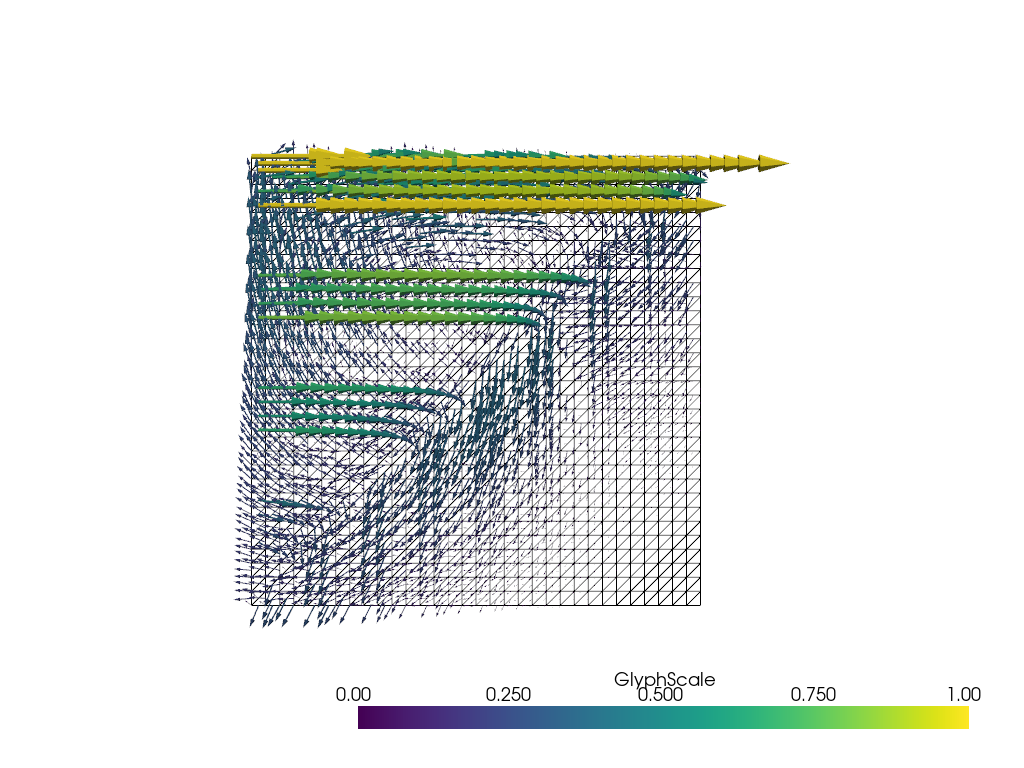

In [52]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_s)] = u_s.x.array.real.reshape((geometry.shape[0], len(u_s)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
msh.topology.create_connectivity(msh.topology.dim, msh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(msh, msh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
fig_as_array = plotter.screenshot("glyphs.png")
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")